In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x=np.linspace(0,50,501)

In [3]:
y=np.sin(x)

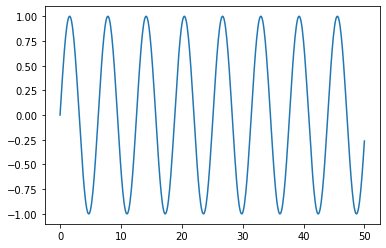

In [4]:
plt.plot(x,y)

In [5]:
from sklearn.preprocessing import MinMaxScaler
df=pd.DataFrame(index=x,data=y,columns=['sine'])
df

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [6]:
len(df)

501

In [7]:
#two things we need to define
#one: the amount of samples we want for the test set as a percentage
#the amount of samples we want in terms of number of samples
test_percent=0.1
test_point=np.round(len(df)*test_percent)

In [8]:
test_point

50.0

In [9]:
#now we obtain the test index
test_ind=int(len(df)-test_point)

In [10]:
test_ind

451

Now we split into train and test sets

In [11]:
train=df.iloc[:test_ind]

In [12]:
test=df.iloc[test_ind:]

In [13]:
print("lenghth of train set: ",len(train))
print("lenghth of test set: ",len(test))

lenghth of train set:  451
lenghth of test set:  50


**Now we scale the data** 

In [14]:
from sklearn.preprocessing import MinMaxScaler 

In [15]:
scaler=MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train=scaler.transform(train)

In [18]:
scaled_test=scaler.transform(test)

Now we create batches for tarining purposes

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
len(scaled_test)

50

In [21]:
scaled_test

array([[9.49551344e-01],
       [9.69156618e-01],
       [9.84074225e-01],
       [9.94155114e-01],
       [9.99298559e-01],
       [9.99453170e-01],
       [9.94617400e-01],
       [9.84839568e-01],
       [9.70217371e-01],
       [9.50896908e-01],
       [9.27071224e-01],
       [8.98978376e-01],
       [8.66899060e-01],
       [8.31153800e-01],
       [7.92099752e-01],
       [7.50127132e-01],
       [7.05655314e-01],
       [6.59128649e-01],
       [6.11012013e-01],
       [5.61786173e-01],
       [5.11942978e-01],
       [4.61980443e-01],
       [4.12397778e-01],
       [3.63690397e-01],
       [3.16344967e-01],
       [2.70834550e-01],
       [2.27613868e-01],
       [1.87114770e-01],
       [1.49741909e-01],
       [1.15868702e-01],
       [8.58335998e-02],
       [5.99367021e-02],
       [3.84367625e-02],
       [2.15486014e-02],
       [9.44095974e-03],
       [2.23481297e-03],
       [2.16257798e-06],
       [2.76531647e-03],
       [1.04966661e-02],
       [2.31189624e-02],


In [ ]:
#the length of the generators datasets should be greater tahn the length e.g the scaled_test set has a length of 50
#hence the length of the length provided should be 49


**To include early stopping we need to initialize a validation genrator as well**

In [23]:
length =49

generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

validation_generator=TimeseriesGenerator(scaled_test,scaled_test,length=length, batch_size=1)

**Now we are essentially taking 49 points and predicting the 50th**

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
earlystop=EarlyStopping(monitor='val_loss',patience=2)

In [27]:
n_features=1

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

In [29]:
model=Sequential()
model.add(LSTM(50,input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')

In [30]:
model.fit_generator(generator,validation_data=validation_generator,epochs=10,callbacks=[earlystop])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


402/402 [==============================] - 9s 18ms/step - loss: 0.0187 - val_loss: 2.0640e-04
Epoch 2/10
402/402 [==============================] - 7s 17ms/step - loss: 1.8173e-04 - val_loss: 6.4728e-05
Epoch 3/10
402/402 [==============================] - 7s 18ms/step - loss: 8.2364e-05 - val_loss: 4.6721e-05
Epoch 4/10
402/402 [==============================] - 7s 17ms/step - loss: 1.6033e-04 - val_loss: 6.6656e-08
Epoch 5/10
402/402 [==============================] - 7s 16ms/step - loss: 1.3394e-04 - val_loss: 9.2009e-05
Epoch 6/10
402/402 [==============================] - 7s 17ms/step - loss: 2.9651e-04 - val_loss: 8.9796e-06


In [35]:
test_predictions=[]
first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
  current_pred=model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


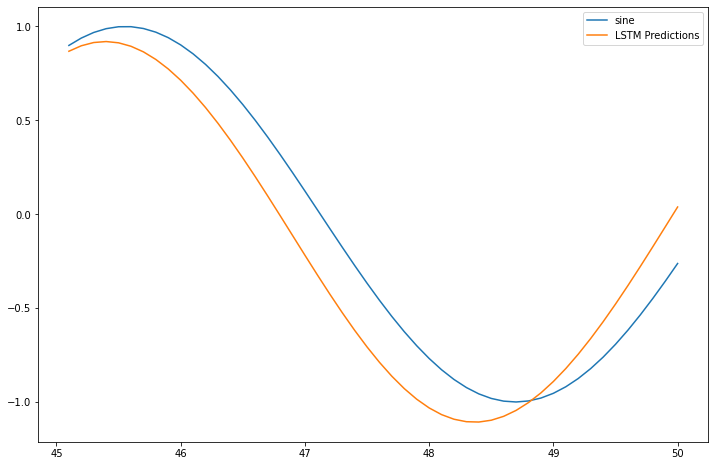

In [36]:
from IPython.core.pylabtools import figsize
true_predictions=scaler.inverse_transform(test_predictions)
test['LSTM Predictions']=true_predictions
test.plot(figsize=(12,8))

# Forecasting
for this purpose well be retraining on all our data

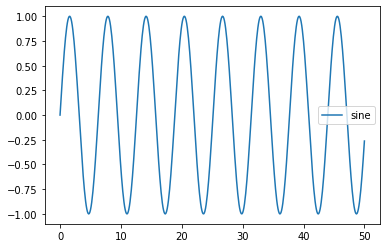

In [37]:
df.plot()

In [38]:
full_scaler=MinMaxScaler()
scaled_full_data=full_scaler.fit_transform(df)

In [39]:
generator=TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [40]:
#redefining our model
model=Sequential()
model.add(LSTM(50,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam') 

In [42]:
model.fit_generator(generator,epochs=6)

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


452/452 [==============================] - 10s 17ms/step - loss: 0.0168
Epoch 2/6
452/452 [==============================] - 8s 17ms/step - loss: 5.6167e-05
Epoch 3/6
452/452 [==============================] - 8s 17ms/step - loss: 1.6824e-04
Epoch 4/6
452/452 [==============================] - 8s 17ms/step - loss: 1.2360e-04
Epoch 5/6
452/452 [==============================] - 8s 17ms/step - loss: 1.7618e-04
Epoch 6/6
452/452 [==============================] - 8s 18ms/step - loss: 4.7903e-05


In [44]:
forecast=[]
first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape(1,length,n_features)
#number of points we want to forecast
for i in range(25):
  current_pred=model.predict(current_batch)[0]
  forecast.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)  


In [45]:
df

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [46]:
forecast

[array([0.94265485], dtype=float32),
 array([0.9602106], dtype=float32),
 array([0.9727425], dtype=float32),
 array([0.9801793], dtype=float32),
 array([0.98252064], dtype=float32),
 array([0.9798143], dtype=float32),
 array([0.9721544], dtype=float32),
 array([0.95967644], dtype=float32),
 array([0.94255346], dtype=float32),
 array([0.9209924], dtype=float32),
 array([0.8952295], dtype=float32),
 array([0.865528], dtype=float32),
 array([0.83217436], dtype=float32),
 array([0.79547864], dtype=float32),
 array([0.75577235], dtype=float32),
 array([0.7134092], dtype=float32),
 array([0.6687652], dtype=float32),
 array([0.6222393], dtype=float32),
 array([0.5742539], dtype=float32),
 array([0.5252549], dtype=float32),
 array([0.47571027], dtype=float32),
 array([0.42610845], dtype=float32),
 array([0.37695384], dtype=float32),
 array([0.32876235], dtype=float32),
 array([0.2820538], dtype=float32)]

In [47]:
#now we inverse transform our forecast so its in the same format as the dataframe
forecast=scaler.inverse_transform(forecast)

In [48]:
forecast

array([[ 0.88530436],
       [ 0.92041562],
       [ 0.94547918],
       [ 0.96035268],
       [ 0.9650353 ],
       [ 0.95962265],
       [ 0.94430295],
       [ 0.91934728],
       [ 0.88510159],
       [ 0.84197976],
       [ 0.79045446],
       [ 0.73105188],
       [ 0.66434516],
       [ 0.59095431],
       [ 0.51154237],
       [ 0.42681671],
       [ 0.33752943],
       [ 0.24447839],
       [ 0.14850841],
       [ 0.05051117],
       [-0.0485773 ],
       [-0.14778015],
       [-0.24608858],
       [-0.34247078],
       [-0.43588714]])

The index of our forecast should start from 50.1, and it should go upto 52.6 as the entries on our df end at 50

In [49]:
len(forecast)

25

In [50]:
#step size=0.1, so we need to go uptil
25*0.1

2.5

In [52]:
forecast_index=np.arange(50.1,52.6,step=0.1)

In [53]:
len(forecast)

25

In [54]:
len(forecast_index)

25

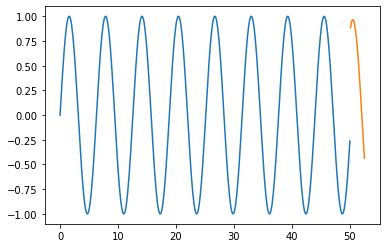

In [55]:
plt.plot(df.index,df['sine'])
plt.plot(forecast_index,forecast)